# Neural net benchmarking and visualization

Here, the neural net heuristic, the diagonal heuristic and the weighted diagonal heuristic are benchmarked with random source-target pairs. Runtime and predicted LCPC is recorded. (Calculating the error was an afterthought and is done in 9eCheck.ipynb, together with the visualization of the neural A* benchmark.)

Furthermore, the performance of the neural heuristic is compared visually with the the results of the weighted diagonal heuristic. This is done for all near LCPCs with vertex 11528260 as a source.

1. [Definitions](#Definitions)
2. [s-t pairs](#s-t-pairs)
   1. [Neural](#Neural)
   2. [Diagonal heuristic](#Diagonal-heuristic)
   3. [Weighted diagonal heuristic](#Weighted-diagonal-heuristic)
4. [11528260 Vis](#11528260-Vis)
   1. [Calculate Neural near LCPCs](#Calculate-Neural-near-LCPCs)
   2. [Calculate weighted near LCPCs](#Calculate-weighted-near-LCPCs)
   3. [Neural Vis](#Neural-Vis)
   4. [Weighted Vis](#Weighted-Vis)


In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import time
from datetime import datetime
import os

In [2]:
from functools import partial
import os
import tempfile
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Computer Modern']

In [6]:
adj = sp.sparse.load_npz('data/mb_50m_cost0-union_adj-COO-arr.npz')

## Definitions

In [5]:
#define nn model
class SP_coord_V1_0_RT(nn.Module):
    def __init__(self,o1=8*4,o2=4*4,o3=2*4,o4=4):
        super(SP_coord_V1_0_RT, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, o1),
            nn.ReLU(),
            nn.Linear(o1, o2),
            nn.ReLU(),
            nn.Linear(o2, o3),
            nn.ReLU(),
            nn.Linear(o3,  o4),
            nn.ReLU(),
            nn.Linear(o4, 1) #To guarantee positve values another ReLU could be put here
        )
    def forward(self, x):
        pred = self.linear_relu_stack(x)
        return pred

In [6]:
#define custom relative loss function
class Cust_RelLoss(nn.Module):
  def __init__(self):
    super(Cust_RelLoss, self).__init__();

  def forward(self, dist_pred, dist_label):
    rel_loss = torch.sum(torch.abs(dist_pred-dist_label)/dist_label)/len(dist_label)
    return rel_loss

In [7]:
#define dataset class
# https://machinelearningmastery.com/training-a-pytorch-model-with-dataloader-and-dataset/ 
class DistDataset(Dataset):
    def __init__(self, data):
        #make source target pairs and corresponding distance list from data
        self.coords = data[:,0]
        self.distances = data[:,1]
 
    def __len__(self):
        # this should return the size of the dataset
        return len(self.coords)
 
    def __getitem__(self, idx):
        # this should return one sample from the dataset
        features = torch.tensor(self.coords[idx],dtype=torch.float32)
        target = torch.tensor(self.distances[idx],dtype=torch.float32)#maybe use float64?
        return features, target

In [4]:
def ind_to_coord(node_ind, shape=(5100,4520)):
    return int(node_ind/shape[1]), int(node_ind % shape[1])

In [9]:
adj.data.min()

0.0014285714

In [5]:
def eight_neighb_heuristic(node, goal, shape=(5100,4520),min_cost_fac=1.25): #http://theory.stanford.edu/~amitp/GameProgramming/Heuristics.html
    min_cost = min_cost_fac*0.0014285714
    min_cost_diag = np.sqrt(2)*min_cost
    dx = abs(node[1] - goal[1])
    dy = abs(node[0] - goal[0])
    return min_cost * (dx + dy) + (min_cost_diag - 2 * min_cost) * min(dx, dy)

In [11]:
device = "cpu"
load_model =  SP_coord_V1_0_RT()
load_model.load_state_dict(torch.load('data/models/coords_V1_0_full_best-ep_15_2024-07-23_21-33.pth'))
load_model.to(device)
def nn_heur(s_row, s_col,t_row, t_col):
    #s_row, s_col = ind_to_coord(source)
    with torch.no_grad():
        cost_tensor= load_model(torch.tensor([s_row, s_col,  t_row, t_col],dtype=torch.float32))
    return cost_tensor.numpy()[0]

## s-t pairs

### Neural

In [18]:
def nn_SSST_bench(num_st_pairs):
    results =  pd.DataFrame(columns=['source','target','distance','time'])
    st=np.random.permutation(np.unique(adj.coords[0]))[:2*num_st_pairs]
    sources=st[:num_st_pairs]
    targets=st[num_st_pairs:]
    for ind,(s,t) in enumerate(zip(sources,targets)):
        print(ind)
        s_row, s_col = ind_to_coord(s)
        t_row, t_col = ind_to_coord(t)
        t_start=time.time()
        nn_cost = nn_heur(s_row, s_col,t_row, t_col)
        t_elapsed = time.time()-t_start
        results.loc[ind] = [s,t,nn_cost,t_elapsed]
        print(nn_cost)
        print(t_elapsed)
    
    results.to_csv(f'data/bench/neuralnet/nn_SSST_res_{num_st_pairs}.csv')
    return results

In [19]:
bench_res = nn_SSST_bench(20)

0
3.8871765
0.0006077289581298828
1
6.4979987
0.00022363662719726562
2
5.3522177
0.00019288063049316406
3
6.0609026
0.00018548965454101562
4
7.047938
0.00018548965454101562
5
2.4610176
0.0001842975616455078
6
5.693563
0.00022363662719726562
7
5.8324347
0.00018858909606933594
8
3.3816385
0.00022125244140625
9
3.074345
0.00023031234741210938
10
9.613821
0.00023555755615234375
11
2.4231553
0.0002224445343017578
12
3.3861766
0.00019931793212890625
13
2.3509297
0.00018978118896484375
14
2.5642772
0.00019288063049316406
15
1.6652269
0.00018548965454101562
16
4.785429
0.00018405914306640625
17
2.1688013
0.0001842975616455078
18
2.317006
0.0001857280731201172
19
1.3960356
0.00022339820861816406


In [20]:
bench_res

source      target  distance      time
0   11511360.0   9303701.0  3.887177  0.000608
1    1914952.0  15925953.0  6.497999  0.000224
2    4318611.0  16252127.0  5.352218  0.000193
3   17732718.0  11262990.0  6.060903  0.000185
4    4405480.0  18953838.0  7.047938  0.000185
5   22331959.0  16727559.0  2.461018  0.000184
6    8164769.0  20871196.0  5.693563  0.000224
7   17536418.0   7391644.0  5.832435  0.000189
8   13458810.0  12281815.0  3.381639  0.000221
9    8477046.0  13915407.0  3.074345  0.000230
10  20340218.0   2213595.0  9.613821  0.000236
11   9647256.0  15079961.0  2.423155  0.000222
12  17497932.0  20970927.0  3.386177  0.000199
13  20910513.0  15541173.0  2.350930  0.000190
14   8553777.0  13959363.0  2.564277  0.000193
15   1227992.0   5612376.0  1.665227  0.000185
16  18463209.0  10312123.0  4.785429  0.000184
17  19225415.0  17694258.0  2.168801  0.000184
18   4519224.0   7234738.0  2.317006  0.000186
19   8757071.0   8368970.0  1.396036  0.000223

### Diagonal heuristic

In [7]:
def std_SSST_bench(num_st_pairs):
    results =  pd.DataFrame(columns=['source','target','distance','time'])
    st=np.random.permutation(np.unique(adj.coords[0]))[:2*num_st_pairs]
    sources=st[:num_st_pairs]
    targets=st[num_st_pairs:]
    for ind,(s,t) in enumerate(zip(sources,targets)):
        print(ind)
        s_row, s_col = ind_to_coord(s)
        t_row, t_col = ind_to_coord(t)
        t_start=time.time()
        nn_cost = eight_neighb_heuristic((s_row, s_col),(t_row, t_col),min_cost_fac=1)
        t_elapsed = time.time()-t_start
        results.loc[ind] = [s,t,nn_cost,t_elapsed]
        print(nn_cost)
        print(t_elapsed)
    
    results.to_csv(f'data/bench/neuralnet/std_SSST_res_{num_st_pairs}.csv')
    return results

In [8]:
bench_res =std_SSST_bench(20)

0
1.8460987050006135
2.2172927856445312e-05
1
4.708468571025422
8.58306884765625e-06
2
3.185842132345791
7.62939453125e-06
3
2.0874503803604907
7.62939453125e-06
4
1.796345560802147
7.3909759521484375e-06
5
1.2408644357846865
7.152557373046875e-06
6
5.142835394426647
6.67572021484375e-06
7
2.00181597623063
7.3909759521484375e-06
8
2.453021080101379
6.67572021484375e-06
9
1.467723119696479
6.4373016357421875e-06
10
4.302719968168765
6.4373016357421875e-06
11
2.202882245771214
6.9141387939453125e-06
12
1.4637521856480875
6.67572021484375e-06
13
3.375951381948245
7.62939453125e-06
14
1.6689660552217471
7.62939453125e-06
15
2.0864933602223608
7.867813110351562e-06
16
4.351631535286983
7.867813110351562e-06
17
1.3405874802875966
7.62939453125e-06
18
5.228220980660648
6.4373016357421875e-06
19
4.440417967494031
6.67572021484375e-06


In [9]:
bench_res

source      target  distance      time
0   17788223.0  16749820.0  1.846099  0.000022
1   17500305.0   3356822.0  4.708469  0.000009
2    6533670.0  15600249.0  3.185842  0.000008
3   13409326.0   7148942.0  2.087450  0.000008
4   12387509.0  16027033.0  1.796346  0.000007
5   11070939.0   7382746.0  1.240864  0.000007
6    3220290.0  19098840.0  5.142835  0.000007
7    8813233.0   3226114.0  2.001816  0.000007
8    8098607.0  15502558.0  2.453021  0.000007
9    7592183.0   3528393.0  1.467723  0.000006
10   3256269.0  14378659.0  4.302720  0.000006
11   5716193.0   9984224.0  2.202882  0.000007
12   7456207.0  11293263.0  1.463752  0.000007
13  15520838.0   8915360.0  3.375951  0.000008
14  13536230.0  12048118.0  1.668966  0.000008
15  11222388.0  13747839.0  2.086493  0.000008
16   5118507.0  18868357.0  4.351632  0.000008
17  19507009.0  15714489.0  1.340587  0.000008
18  15929288.0  21451362.0  5.228221  0.000006
19   6664317.0  19410021.0  4.440418  0.000007

### Weighted diagonal heuristic

In [10]:
def stdw_SSST_bench(num_st_pairs):
    results =  pd.DataFrame(columns=['source','target','distance','time'])
    st=np.random.permutation(np.unique(adj.coords[0]))[:2*num_st_pairs]
    sources=st[:num_st_pairs]
    targets=st[num_st_pairs:]
    for ind,(s,t) in enumerate(zip(sources,targets)):
        print(ind)
        s_row, s_col = ind_to_coord(s)
        t_row, t_col = ind_to_coord(t)
        t_start=time.time()
        nn_cost = eight_neighb_heuristic((s_row, s_col),(t_row, t_col),min_cost_fac=1.25)
        t_elapsed = time.time()-t_start
        results.loc[ind] = [s,t,nn_cost,t_elapsed]
        print(nn_cost)
        print(t_elapsed)
    
    results.to_csv(f'data/bench/neuralnet/stdw_SSST_res_{num_st_pairs}.csv')
    return results

In [11]:
bench_res =stdw_SSST_bench(20)

0
5.320122414546716
1.33514404296875e-05
1
0.7083413065463258
7.152557373046875e-06
2
2.6989417849942616
6.9141387939453125e-06
3
3.8340899300960953
7.3909759521484375e-06
4
3.4318295777565115
7.3909759521484375e-06
5
5.692136040876727
7.3909759521484375e-06
6
7.745202630492738
8.344650268554688e-06
7
3.3506997883177645
7.3909759521484375e-06
8
4.675823573794416
6.4373016357421875e-06
9
1.8348100517653176
6.4373016357421875e-06
10
7.423820707851081
6.4373016357421875e-06
11
6.7671298297213
6.67572021484375e-06
12
7.185936897360273
6.9141387939453125e-06
13
1.8424260074410443
6.67572021484375e-06
14
5.936422134852611
6.4373016357421875e-06
15
5.734653821620599
6.198883056640625e-06
16
1.5845179788273374
6.4373016357421875e-06
17
1.5540429487618699
6.4373016357421875e-06
18
5.388800394007662
6.4373016357421875e-06
19
4.7150604565624095
6.67572021484375e-06


In [12]:
bench_res

source      target  distance      time
0   13724884.0   3298867.0  5.320122  0.000013
1     369082.0   1784044.0  0.708341  0.000007
2   13118479.0   9110383.0  2.698942  0.000007
3   15289662.0   5833689.0  3.834090  0.000007
4   18750731.0  11278522.0  3.431830  0.000007
5   18851656.0   6023052.0  5.692136  0.000007
6    2869144.0  18004238.0  7.745203  0.000008
7   17801083.0  17296673.0  3.350700  0.000007
8    6239667.0  16327374.0  4.675824  0.000006
9   18457889.0  15375994.0  1.834810  0.000006
10  18851729.0   3106941.0  7.423821  0.000006
11  19423169.0   8234413.0  6.767130  0.000007
12   6886804.0  20525735.0  7.185937  0.000007
13   8076180.0  10669866.0  1.842426  0.000007
14  14603000.0  21086470.0  5.936422  0.000006
15  12823886.0  14228169.0  5.734654  0.000006
16  10351813.0   7043548.0  1.584518  0.000006
17  16611374.0  19983594.0  1.554043  0.000006
18   5210191.0  16988317.0  5.388800  0.000006
19   4025193.0  13875387.0  4.715060  0.000007

## 11528260 Vis

### Calculate Neural near LCPCs

In [12]:
s_ind=11528260
s_row, s_col = ind_to_coord(s_ind)
ind_arr = np.union1d(adj.row,adj.col)

In [13]:
#takes 2501.18 s -> way to long
#rather use parallelization with tensors
'''
#neural net heur
dist_nn_heur = np.full(adj.shape[0], np.nan, dtype=np.float32)
a=time.time()
with torch.no_grad():
    for ind in ind_arr:
        row, col = ind_to_coord(ind)
        dist_nn_heur[ind] = load_model(torch.tensor([s_row, s_col,  row, col],dtype=torch.float32)).numpy()[0]
dist_nn_heur[s_ind]=0
print(time.time()-a)
'''

'\n#neural net heur\ndist_nn_heur = np.full(adj.shape[0], np.nan, dtype=np.float32)\na=time.time()\nwith torch.no_grad():\n    for ind in ind_arr:\n        row, col = ind_to_coord(ind)\n        dist_nn_heur[ind] = load_model(torch.tensor([s_row, s_col,  row, col],dtype=torch.float32)).numpy()[0]\ndist_nn_heur[s_ind]=0\nprint(time.time()-a)\n'

In [14]:
data=np.load(f'data/vis/full_coords-dist_{11528260}.npy',allow_pickle=True)
dataset = DistDataset(data)

In [15]:
#could be sped up if non connected vertices would be excluded
a=time.time()
datloader= torch.utils.data.DataLoader(dataset, batch_size=1000000, shuffle=False)
tensors = []
with torch.no_grad():
    for batch, data in enumerate(datloader):
        coords, dist_label = data
        coords, dist_label = coords.to(device), dist_label.to(device)
        dist_tensor = load_model(coords)
        tensors.append(dist_tensor)
        print(batch+1)
dist_nn_heur = torch.cat(tensors).numpy()
print(time.time()-a)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
396.1133961677551


In [17]:
dist_nn_heur.size

23052000

### Calculate weighted near LCPCs

In [19]:
dist_std_w_heur = np.full(adj.shape[0], np.nan, dtype=np.float32)
a=time.time()
for ind in ind_arr:
    row, col = ind_to_coord(ind)
    dist_std_w_heur[ind] = eight_neighb_heuristic((row,col),(s_row,s_col))
print(time.time()-a)

130.114275932312


### Neural Vis

In [20]:
dist_nn_heur[s_ind]

array([0.13570344], dtype=float32)

In [ ]:
#to prohibit infinite relative error
dist_nn_heur[s_ind]=0

In [30]:
dist_load=np.load(f'data/bench/dijkstra_self/SSSP_11528260.npy',allow_pickle=True)[:,0]
dist_nn_heur[dist_load==np.inf] = np.nan
dist_load[dist_load==np.inf] = np.nan

In [73]:
#calculate error
nn_err=dist_nn_heur.reshape((5100,4520))-dist_load.reshape((5100,4520))
print(np.nanmean(nn_err))
print(np.nanstd(nn_err))
print(np.nanmax(nn_err))
print(np.nanmin(nn_err))

-0.21863781725701678
1.123878787601612
0.46354908123612404
-32.59124998457264


In [74]:
#calculate abs error
nn_aerr = np.abs(nn_err)
print(np.nanmean(nn_aerr))
print(np.nanstd(nn_aerr))
print(np.nanmax(nn_aerr))
print(np.nanmin(nn_aerr))

0.3366173857741402
1.0943467274819108
32.59124998457264
0.0


In [75]:
#calculate relative error
nn_rerr = nn_aerr/dist_load.reshape((5100,4520))
print(np.nanmean(nn_rerr))
print(np.nanstd(nn_rerr))
print(np.nanmax(nn_rerr))
print(np.nanmin(nn_rerr))

/tmp/ipykernel_238810/1660744251.py:1: RuntimeWarning: invalid value encountered in divide
  nn_rerr = nn_aerr/dist_load.reshape((5100,4520))


0.08861822133089556
0.1429985394714183
93.99241215401584
3.759600934656594e-09


In [85]:
plt.imshow(dist_nn_heur.reshape((5100,4520)), cmap='gist_ncar', vmin=0.0, vmax=np.nanmax(dist_load), interpolation='none')
plt.colorbar(label=r'cost $(145\, \mathrm{EUR}) $')
plt.xlabel(r'x position $(50\, \mathrm{m}) $')
plt.ylabel(r'y position $(50\, \mathrm{m}) $')

text=  (r'\noindent ca. $400+100\, \mathrm{s}$ (runtime+training) $\newline$'
        r'$8.86(1430) \, \%$ rel. error$\newline$'
        r'$0.34(109) \times 145\, \mathrm{EUR}$ abs. error \newline')

plt.text(2820,220 , text, fontsize=9, bbox=dict(boxstyle='round', fc='white', ec='black',alpha=0.5),  horizontalalignment='right')


plt.savefig('data/vis/nn/nn_heur_11528260.pdf', format='pdf')
plt.show()

In [105]:
plt.imshow(nn_rerr, cmap='gist_ncar_r', vmin=0.0, vmax=5, interpolation='none')
plt.colorbar(label=r'relative error')
plt.xlabel(r'x position $(50\, \mathrm{m}) $')
plt.ylabel(r'y position $(50\, \mathrm{m}) $')

text=  (r'\noindent $8.86(1430) \, \%$ mean$\newline$'
        r'$9399.24 \, \%$ max.$\newline$'
        r'$3.76  \times 10^{-7}\, \%$ min.\newline')

plt.text(1600,220 , text, fontsize=9, bbox=dict(boxstyle='round', fc='white', ec='black',alpha=0.5),  horizontalalignment='right')


plt.savefig('data/vis/nn/nn_heur_rerr_11528260.pdf', format='pdf')
plt.show()

In [121]:
plt.imshow(nn_aerr, cmap='gist_ncar_r', vmin=0.0, vmax=10, interpolation='none')
plt.colorbar(label=r'absolute error $(145\, \mathrm{EUR}) $')
plt.xlabel(r'x position $(50\, \mathrm{m}) $')
plt.ylabel(r'y position $(50\, \mathrm{m}) $')

text=  (r'\noindent $0.34(109) \times 145\, \mathrm{EUR}$ mean$\newline$'
        r'$32.59 \times 145\, \mathrm{EUR}$ max.$\newline$'
        r'$0 \times 145\, \mathrm{EUR}$ min $\newline$')

plt.text(2200,220 , text, fontsize=9, bbox=dict(boxstyle='round', fc='white', ec='black',alpha=0.5),  horizontalalignment='right')


plt.savefig('data/vis/nn/nn_heur_aerr_11528260.pdf', format='pdf')
plt.show()

In [ ]:
#maybe do A* with it

In [134]:
pos= np.full((5100,4520), np.nan, dtype=np.float32)
pos[nn_err>0]=1

In [135]:
plt.imshow(pos, cmap='binary', vmin=0, vmax=1, interpolation='none')
#plt.imshow(path.reshape((5100,4520)), cmap='OrRd', vmin=0, vmax=1, interpolation='none')
#plt.plot(x_sort,y_sort)
#plt.colorbar(label=r'distance $(145\, \mathrm{EUR}) $')
plt.plot(2260,2550, color='red',marker=7,linestyle='')
patches = [mpatches.Patch(color='black', label='positive error'),mlines.Line2D([], [], color='red', marker=7, label=r'source vertex',linestyle='')]
plt.legend(handles=patches, loc=2)
plt.xlabel(r'x position $(50\, \mathrm{m}) $')
plt.ylabel(r'y position $(50\, \mathrm{m}) $')



plt.savefig('data/vis/nn/nn_heur_pos_11528260.pdf', format='pdf')
plt.show()

In [136]:
neg= np.full((5100,4520), np.nan, dtype=np.float32)
neg[nn_err<0]=1

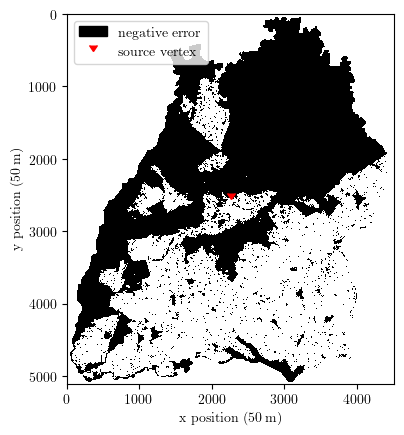

In [137]:
plt.imshow(neg, cmap='binary', vmin=0, vmax=1, interpolation='none')
#plt.imshow(path.reshape((5100,4520)), cmap='OrRd', vmin=0, vmax=1, interpolation='none')
#plt.plot(x_sort,y_sort)
#plt.colorbar(label=r'distance $(145\, \mathrm{EUR}) $')
plt.plot(2260,2550, color='red',marker=7,linestyle='')
patches = [mpatches.Patch(color='black', label='negative error'),mlines.Line2D([], [], color='red', marker=7, label=r'source vertex',linestyle='')]
plt.legend(handles=patches, loc=2)
plt.xlabel(r'x position $(50\, \mathrm{m}) $')
plt.ylabel(r'y position $(50\, \mathrm{m}) $')



plt.savefig('data/vis/nn/nn_heur_neg_11528260.pdf', format='pdf')
plt.show()

### Weighted Vis

In [111]:
std_err=dist_std_w_heur.reshape((5100,4520))-dist_load.reshape((5100,4520))
print(np.nanmean(std_err))
print(np.nanstd(std_err))
print(np.nanmax(std_err))
print(np.nanmin(std_err))

-0.3791373702883971
1.146588503957685
0.29676838673185557
-32.797844928572886


In [112]:
std_aerr = np.abs(std_err)
print(np.nanmean(std_aerr))
print(np.nanstd(std_aerr))
print(np.nanmax(std_aerr))
print(np.nanmin(std_aerr))

0.4198964274601403
1.1322973695824492
32.797844928572886
0.0


In [113]:
std_rerr = std_aerr/dist_load.reshape((5100,4520))
print(np.nanmean(std_rerr))
print(np.nanstd(std_rerr))
print(np.nanmax(std_rerr))
print(np.nanmin(std_rerr))

/tmp/ipykernel_238810/4105995692.py:1: RuntimeWarning: invalid value encountered in divide
  std_rerr = std_aerr/dist_load.reshape((5100,4520))


0.11269691492336903
0.12667506695885092
0.9651595382338357
2.817051235899676e-09


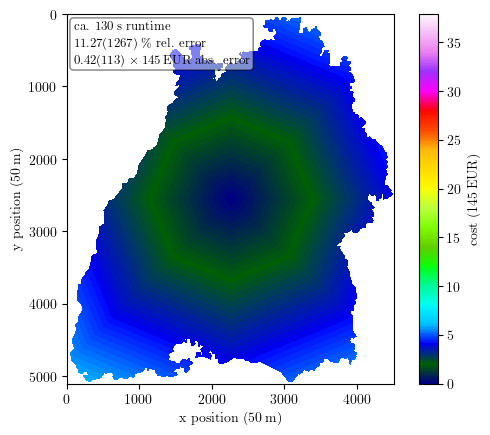

In [118]:
plt.imshow(dist_std_w_heur.reshape((5100,4520)), cmap='gist_ncar', vmin=0.0, vmax=np.nanmax(dist_load), interpolation='none')
plt.colorbar(label=r'cost $(145\, \mathrm{EUR}) $')
plt.xlabel(r'x position $(50\, \mathrm{m}) $')
plt.ylabel(r'y position $(50\, \mathrm{m}) $')

text=  (r'\noindent ca. $130\, \mathrm{s}$ runtime $\newline$'
        r'$11.27(1267) \, \%$ rel. error$\newline$'
        r'$0.42(113) \times 145\, \mathrm{EUR}$ abs. error \newline')

plt.text(2520,220 , text, fontsize=9, bbox=dict(boxstyle='round', fc='white', ec='black',alpha=0.5),  horizontalalignment='right')


plt.savefig('data/vis/nn/std_heur_11528260.pdf', format='pdf')
plt.show()

In [120]:
plt.imshow(std_rerr, cmap='gist_ncar_r', vmin=0.0, vmax=5, interpolation='none')
plt.colorbar(label=r'relative error')
plt.xlabel(r'x position $(50\, \mathrm{m}) $')
plt.ylabel(r'y position $(50\, \mathrm{m}) $')

text=  (r'\noindent $11.27(1267) \, \%$ mean$\newline$'
        r'$96.52 \, \%$ max.$\newline$'
        r'$2.81  \times 10^{-7}\, \%$ min.\newline')

plt.text(1620,220 , text, fontsize=9, bbox=dict(boxstyle='round', fc='white', ec='black',alpha=0.5),  horizontalalignment='right')


plt.savefig('data/vis/nn/std_heur_rerr_11528260.pdf', format='pdf')
plt.show()

In [122]:
plt.imshow(std_aerr, cmap='gist_ncar_r', vmin=0.0, vmax=10, interpolation='none')
plt.colorbar(label=r'cost $(145\, \mathrm{EUR}) $')
plt.xlabel(r'x position $(50\, \mathrm{m}) $')
plt.ylabel(r'y position $(50\, \mathrm{m}) $')

text=  (r'\noindent $0.42(113) \times 145\, \mathrm{EUR}$ mean$\newline$'
        r'$32.80 \times 145\, \mathrm{EUR}$ max.$\newline$'
        r'$0 \times 145\, \mathrm{EUR}$ min $\newline$')

plt.text(2200,220 , text, fontsize=9, bbox=dict(boxstyle='round', fc='white', ec='black',alpha=0.5),  horizontalalignment='right')


plt.savefig('data/vis/nn/std_heur_aerr_11528260.pdf', format='pdf')
plt.show()

In [139]:
pos= np.full((5100,4520), np.nan, dtype=np.float32)
pos[std_err>0]=1

In [140]:
plt.imshow(pos, cmap='binary', vmin=0, vmax=1, interpolation='none')
#plt.imshow(path.reshape((5100,4520)), cmap='OrRd', vmin=0, vmax=1, interpolation='none')
#plt.plot(x_sort,y_sort)
#plt.colorbar(label=r'distance $(145\, \mathrm{EUR}) $')
plt.plot(2260,2550, color='red',marker=7,linestyle='')
patches = [mpatches.Patch(color='black', label='positive error'),mlines.Line2D([], [], color='red', marker=7, label=r'source vertex',linestyle='')]
plt.legend(handles=patches, loc=2)
plt.xlabel(r'x position $(50\, \mathrm{m}) $')
plt.ylabel(r'y position $(50\, \mathrm{m}) $')



plt.savefig('data/vis/nn/std_heur_pos_11528260.pdf', format='pdf')
plt.show()

In [141]:
neg= np.full((5100,4520), np.nan, dtype=np.float32)
neg[std_err<0]=1

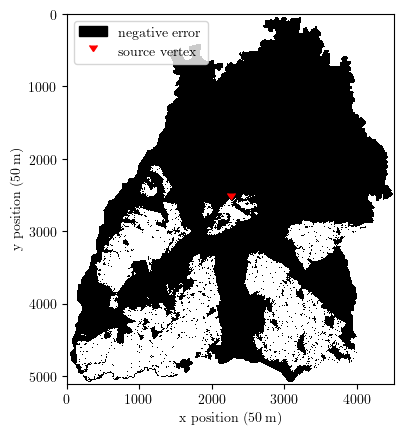

In [142]:
plt.imshow(neg, cmap='binary', vmin=0, vmax=1, interpolation='none')
#plt.imshow(path.reshape((5100,4520)), cmap='OrRd', vmin=0, vmax=1, interpolation='none')
#plt.plot(x_sort,y_sort)
#plt.colorbar(label=r'distance $(145\, \mathrm{EUR}) $')
plt.plot(2260,2550, color='red',marker=7,linestyle='')
patches = [mpatches.Patch(color='black', label='negative error'),mlines.Line2D([], [], color='red', marker=7, label=r'source vertex',linestyle='')]
plt.legend(handles=patches, loc=2)
plt.xlabel(r'x position $(50\, \mathrm{m}) $')
plt.ylabel(r'y position $(50\, \mathrm{m}) $')



plt.savefig('data/vis/nn/std_heur_neg_11528260.pdf', format='pdf')
plt.show()